# Lesson 4: SciPy

While we could manually code up many commonly used tools (like integration, interpolation, etc.) or we could use built in functions within SciPy (i.e. Scientific Python, seems appropriate for a Scientific Programming course!)

SciPy contains a number of sub-modules, some of which I use every day and others I didn't know existed till I prepared this lecture. Below I bolded ones that we are likely to use in the course, although others might be useful for final projects.

> scipy.cluster : Clustering alike data (i.e. group data into discrete groups)

> scipy.constants : Numerical constants (like speed of light, gravitational constant, etc.)

> **scipy.fftpack** : Fourier transforms (more later in the course!)

> **scipy.integrate** : To integrate functions

> **scipy.interpolate** : Interpolate between datapoints

> scipy.io : Save/Load certain data types, usually for compatibility reasons (like MatLab data files)

> **scipy.linalg** : Linear algebra routines (like finding eigenvectors/values

> **scipy.ndimage** : Used to manipulate images (like smoothing)

> scipy.odr : Certain regression types (I've never used this)

> **scipy.optimize** : Finding minima/maxima of functions

> **scipy.signal** : Used to process "signals", stereotypically 1d time seriea data

> scipy.sparse : A special data-type which extends numpy arrays to be very large where only some elements are non-zero (useful if the matrix couldn't be held in memory if explicity declared in numpy)

> scipy.spatial : Holding spatial information, for example database structures to find nearby elements

> **scipy.special** : Many special functions (Bessel, Airy, etc.)

> **scipy.stats** : generate various random distriburtions and perform analysis on them!


## SciPy Integrate

We showed this a bit in an earlier lesson, but just to review...

In [93]:
def func(x):
    return -np.sin(x)*np.exp(-x)

In [94]:
%pylab inline
from scipy import integrate

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [95]:
%timeit integrate.quad(func,0,1,epsabs=1.00e-01)

197 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Very fast! No need to use custom integration script unless you really need to due to weirdly behaved functions...

## Differential Equation Solving

One thing we didn't code up ourselves is numerical differential equation solvers. Those out there who are engineers or physics students have probably seen some of the classic techniques (like Runga-Kutta), and one could go into great depths to discuss the different types of differential equations and how to numerically solve each type. Here we will use some scipy routines to make this easier for us.

For simple Ordinary differential equations we are essentially just integrating:

$$ \frac{dy}{dt} = -2yt$$ 

with boundary condition,

$$ y(0) = 1$$.

Text(0, 0.5, '$y(t)$')

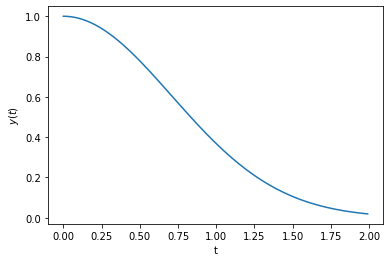

In [92]:
from scipy.integrate import odeint #ordinary differential equation integrator

def f (y , t ):

    return -2 * y * t
y0 = 1 # initial value
a = 0 # integration limits for t
b = 2
t = np.arange (a , b , 0.01) # values of t for
# which we require
# the solution y ( t )
y = odeint (f , y0 , t ) # actual computation of y ( t )

plt.plot(t , y )
plt.xlabel("t")
plt.ylabel ("$y(t)$")


### Interpolation/Extrapolation

Often times it is important to "connect the dots" with data and interpolate between points. Other times we want to go beyond the edges of our available data and extrapolate the points.

Populating the interactive namespace from numpy and matplotlib


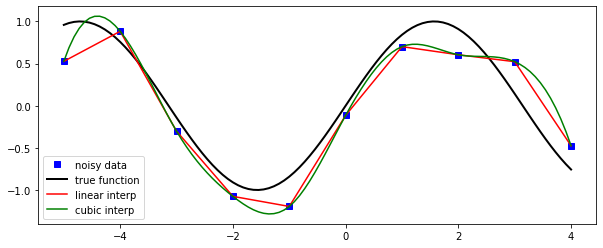

In [77]:
from scipy.interpolate import *
%pylab inline
def f(x):
    return sin(x)
n = arange(-5, 5)
x = linspace(-5, 4, 100)
y_meas = f(n) + 0.2 * randn(len(n)) # simulate noisy data
y_real = f(x)
linear_interpolation = interp1d(n, y_meas)
y_interp1 = linear_interpolation(x)
cubic_interpolation = interp1d(n, y_meas, kind='cubic')
y_interp2 = cubic_interpolation(x)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(n, y_meas, 'bs', label='noisy data')
ax.plot(x, y_real, 'k', lw=2, label='true function')
ax.plot(x, y_interp1, 'r', label='linear interp')
ax.plot(x, y_interp2, 'g', label='cubic interp')
ax.legend(loc=3);

Notice that in either event we add a lot of additional "small scale flucuations" into our data since we are essentially interpolating between noisy points. In this formalism we aren't really including the fact that our points have noise into our interpolation.

Populating the interactive namespace from numpy and matplotlib


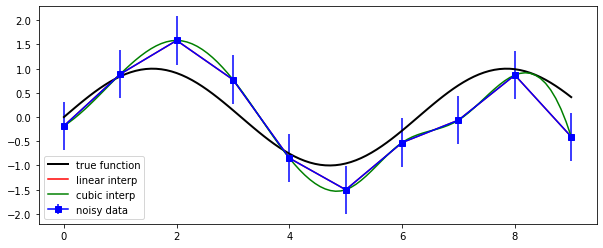

In [78]:
from scipy.interpolate import *
%pylab inline
def f(x):
    return sin(x)
n = arange(0, 10)
x = linspace(0, 9, 100)
y_meas = f(n) + 0.5 * randn(len(n)) # simulate noisy data
y_real = f(x)
linear_interpolation = interp1d(n, y_meas)
y_interp1 = linear_interpolation(x)
cubic_interpolation = interp1d(n, y_meas, kind='cubic')
y_interp2 = cubic_interpolation(x)

fig, ax = plt.subplots(figsize=(10,4))
ax.errorbar(n, y_meas,0.5*np.ones(10), color='b',marker="s", label='noisy data')
ax.plot(x, y_real, 'k', lw=2, label='true function')
ax.plot(x, y_interp1, 'r', label='linear interp')
ax.plot(x, y_interp2, 'g', label='cubic interp')
ax.legend(loc=3);

Depending on the origin of our data, we might have a functional form to fit to the data based on our understanding of physics (like in the damped harmonic oscillator case) using a simple likelihood-type calculation (the chi-squared). In many cases though the physics is either unknown or we don't have a good enough model to deal with the noise in the data. In these cases we often do the one of the following:

1) Fit a line.

2) Fit a line in log-log space. (which is equivalent to a power-law, $y = x^a$)

3) Use a more complicated ansatz and figure out the parameters (a guess about what y(x) equals).

4) Use all possible functions! (Gaussian Process Regression)

## Gaussian Processes

Now (4) probably seems crazy! But it actually isn't so hard to implement...

We start off with some "prior" over possible functions, defined by a covariance matrix. This covariance matrix is mostly there just to keep things "smooth" and not simply hit every point in the jagged way of the linear fit. Once we see the data, we update our prior based on a likelihood calculation.

For a more thorough description, see [here](https://katbailey.github.io/post/gaussian-processes-for-dummies/).

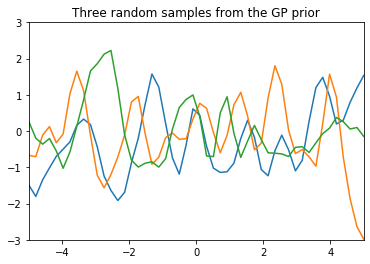

In [31]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function, this is where the covariance matrix implicitly enters
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three random samples from the GP prior')
pl.show()

In [34]:
#data to "add"
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)


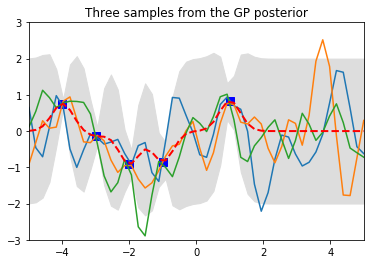

In [35]:


# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

Of course, this is a lot of math/linear algebra to keep track of. Lets instead just use a pre-built package to do this! sklearn! (You will likely need to install this package!)

| pip install sklearn



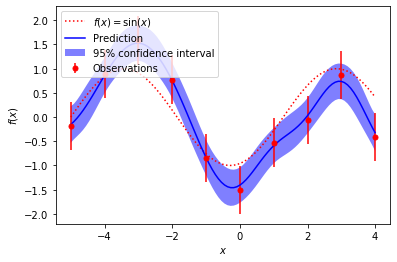

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

#
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))


# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.2 ** 2, #noise
                              n_restarts_optimizer=10)
n = arange(-5, 5)

X = np.atleast_2d(n).T

y = y_meas.ravel()


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = linspace(-5, 4, 100)

# Make the prediction on the meshed x-axis (ask for error as well)
y_pred, sigma = gp.predict(x.reshape(-1, 1), return_std=True)

plt.figure()
plt.plot(x, y_real, 'r:', label=r'$f(x) = \sin(x)$')
plt.errorbar(X.ravel(), y, 0.5, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc=2)

plt.show()

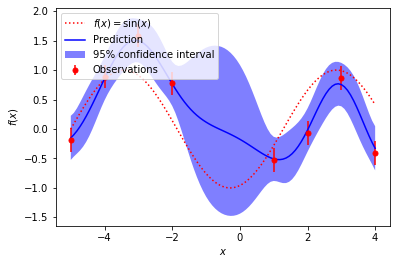

In [86]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

#
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))


# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.2 ** 2, #noise
                              n_restarts_optimizer=10)
n = arange(-5, 5)

filt = [True,True,True,True,False,False,True,True,True,True]

X = np.atleast_2d(n[:10][filt]).T

y = y_meas[:10][filt].ravel()


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = linspace(-5, 4, 100)

# Make the prediction on the meshed x-axis (ask for error as well)
y_pred, sigma = gp.predict(x.reshape(-1, 1), return_std=True)

plt.figure()
plt.plot(x, y_real, 'r:', label=r'$f(x) = \sin(x)$')
plt.errorbar(X.ravel(), y, 0.2, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc=2)

plt.show()

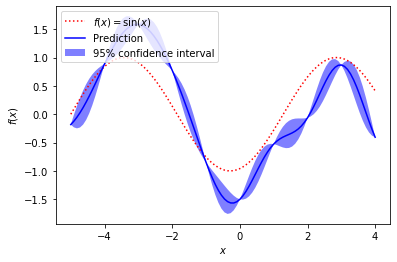

In [89]:
#same plot, no noise


# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, #noise
                              n_restarts_optimizer=10)
n = arange(-5, 5)

X = np.atleast_2d(n).T

y = y_meas.ravel()


# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

x = linspace(-5, 4, 100)

# Make the prediction on the meshed x-axis (ask for error as well)
y_pred, sigma = gp.predict(x.reshape(-1, 1), return_std=True)

plt.figure()
plt.plot(x, y_real, 'r:', label=r'$f(x) = \sin(x)$')
#plt.plot(X.ravel(), y, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc=2)

plt.show()